In [65]:
import missingno as msno
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Conv1D, GlobalAveragePooling1D, MaxPooling1D

导入数据集+选择处理所用数据（选择我们使用数据的哪一列）+构建训练集、测试集(预训练时，百分之  的数据作为训练集；实际预测时，百分之  的数据用作训练集（很小的量，符合工程实际）)

   rongliang
0   1.853511
1   1.853466
2   1.853316
3   1.853061
4   1.852708
5   1.852266


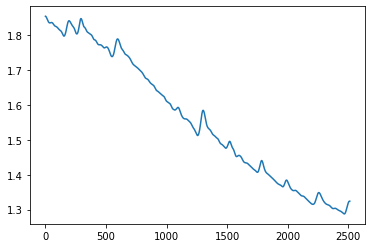

(2011, 1)

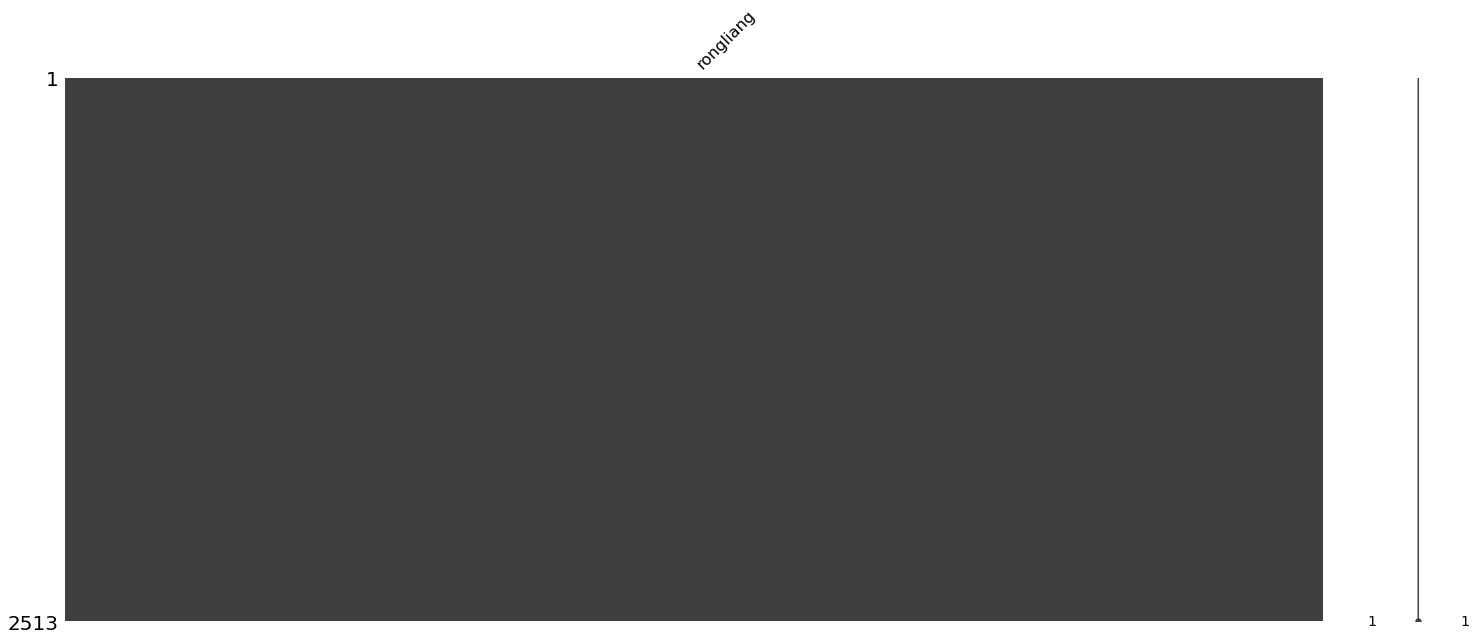

In [115]:
#df = pd.read_csv("B18rongliang.csv", index_col='日期')
df=pd.read_excel("./汇总/IMF5到RES/B05.xls")
print(df.head(6))   #输出前六行的内容
plt.plot(df)
plt.show()

msno.matrix(df)

data = df.sort_index(ascending=True, axis=0)
##只使用股票的收盘价来进行拟合和预测
#dataset=data[['rongliang']].values
dataset=data.values

data.head()
data.shape
dataset.shape

                                                                                    #
#取80%的数据作为训练集
training_data_len=math.ceil(len(dataset)*.8)
train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60*200轮的数据来预测，因此这倒溯了60*200天
test_data = dataset[training_data_len-60: , : ]
                                                                                    #

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.fit_transform(test_data)
scaled_train
scaled_test.shape
scaled_train.shape

训练集、测试集的重构

In [116]:
#训练集的重构
#1 分离x和y
x_train=[]
y_train=[]
                                                                        #
#for i in range(60,len(scaled_train)-10):
#    x_train.append(scaled_train[i-60:i,0])
#    y_train.append(scaled_train[i+10,0])
for i in range(60,len(scaled_train)):
    x_train.append(scaled_train[i-60:i,0])
    y_train.append(scaled_train[i,0])
                                                                        #
#2 将list类型数据转变成array数据
x_train,y_train=np.array(x_train),np.array(y_train)

#3 将二维数据变成三维数据
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

x_train.shape

#测试集的重构
#1 分离x和y
x_test = []
                                                                        #
#y_test = dataset[training_data_len+10: , : ] 
#for i in range(60,len(scaled_test)-10):
#    x_test.append(scaled_test[i-60:i,0])
y_test = dataset[training_data_len: , : ] 
for i in range(60,len(scaled_test)):
    x_test.append(scaled_test[i-60:i,0])
                                                                        #
#2 将list类型数据转变成array数据
x_test = np.array(x_test)
#3 将二维数据变成三维数据
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

x_test.shape

model = tf.keras.models.Sequential()

构建模型

In [117]:
#model = load_model('model.h5')

#构建模型
#初始化模型
model = Sequential()   #只有在第一层指定输入数据的shape时，模型才可以自动推断所有层的shape并build模型
#
#model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
#CNN层
#model.add(Conv1D(filters= 64, kernel_size= 1, activation= 'relu'))

#model.add(Conv1D(10,1,activation='relu',input_shape=(x_train.shape[1],1)))

#池化层
#model.add(MaxPooling1D())

#model.add(MaxPooling1D(1))

#Dropout层
#model.add(Dropout(.1))

'''
model.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
'''
#LSTM层

#model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=100, return_sequences=False,input_shape=(x_train.shape[1],1)))

#Dropout层
#model.add(Dropout(.1))
#LSTM层
#model.add(LSTM(units=50, return_sequences=True))
#LSTM层

#model.add(LSTM(units=100, return_sequences=False))

#Dropout层
model.add(Dropout(.1))
#全连接层

#model.add(Dense(units=1))

#模型编译
model.compile(optimizer='adam', loss='mean_squared_error')

#模型结构
model.summary()
#print(model.summary())

#拟合模型
model.fit(x_train, y_train, batch_size=25, epochs=60)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 60, 10)            20        
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 60, 10)           0         
 g1D)                                                            
                                                                 
 lstm_30 (LSTM)              (None, 60, 100)           44400     
                                                                 
 lstm_31 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                     

保存模型内容（重点是保存参数）

In [118]:
model.save('model.h5')  #HDFS文件，pip install h5py,直接保存整个网络的参数和结构

#保存模型的参数,载入参数
#model.save_weights('my_model_weights.h5')
#model.load_weights('my_model_weights.h5')

#保存模型的结构，载入网络结构
#from keras.models import model_from_json
#json_string = model.to_json()
#model = model_from_json(json_string)

开始预测

In [119]:
#预测
predictions = model.predict(x_test) 
#还原 特征缩放
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 1s 14ms/step


计算AE、MAE、RMSE

In [120]:
predictions_fail = 0
actual_fail = 0
for i in range(len(predictions)):
    if predictions[i][0] <=1.4:
        predictions_fail = i+1+len(dataset)-len(predictions)
        break
for i in range(len(dataset)):
    if dataset[i][0] <=1.4:
        actual_fail= i+1
        break
  
ae = predictions_fail-actual_fail
mae = np.mean(np.abs(y_test - predictions))*100
rmse = np.sqrt(np.mean((y_test - predictions) ** 2))*100
print('预测寿命为',predictions_fail,'实际寿命为',actual_fail,'AE=',ae,'MAE=',mae,'%','RMSE=',rmse,'%')
#predictions=predictions.tolist()
#pre=[]
#for i in len(predictions):
#Spredictions=pd.DataFrame(predictions)
#print(predictions)
#train = data[:training_data_len]
#valid = data[training_data_len:]
#type(valid)
#type(train)

预测寿命为 2012 实际寿命为 1844 AE= 168 MAE= 0.10760166007265659 % RMSE= 0.12722234080812655 %


作图

rongliang    0.001076
dtype: float64
rongliang    0.001272
dtype: float64
      rongliang  Predictions
2011   1.369690     1.372383
2012   1.368884     1.371563
2013   1.368097     1.370770
2014   1.367329     1.370003
2015   1.366582     1.369257
...         ...          ...
2508   1.324085     1.323843
2509   1.324230     1.324172
2510   1.324278     1.324413
2511   1.324230     1.324563
2512   1.324091     1.324620

[502 rows x 2 columns]


C:\Users\parkour\AppData\Local\Temp/ipykernel_79760/182608765.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


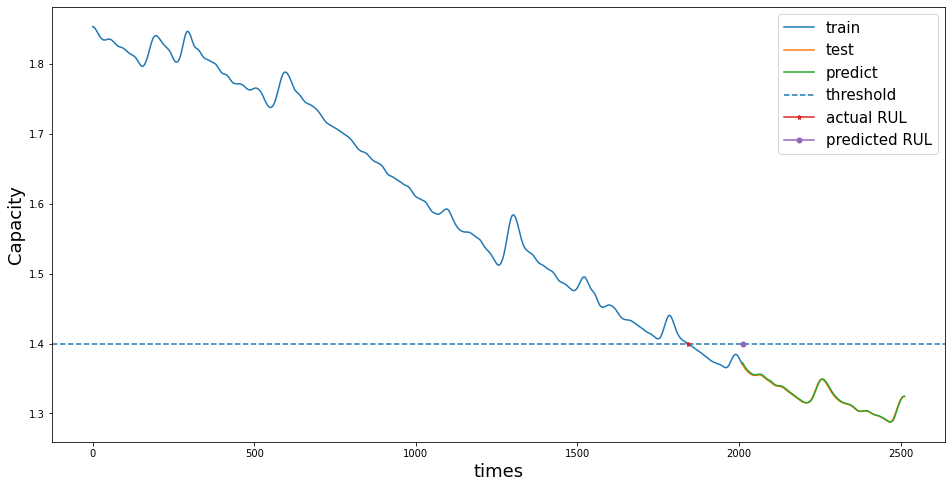

([], [])

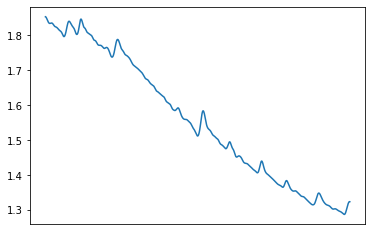

In [121]:
#创建用来画图的dataframe
train = data[:training_data_len+1]    #为了让输出的曲线相连，所以+1
valid = data[training_data_len:]
mae = np.sum(np.absolute(valid - predictions)) / len(valid)
#mse = np.mean(np.power((valid - predictions),2))
rmse = np.sqrt(np.mean(np.power((valid - predictions),2)))
print(mae)
print(rmse)

#predictions.head()    #取数据的前n行数据，默认是5行

#给valid添加新的一列，把预测值predictions赋值给新的一列
#valid['Predictions'] = predictions.values
valid['Predictions'] = predictions
print(valid)
#开始作图
#图像大小
plt.figure(figsize=(16,8))
#x轴
plt.xlabel('times', fontsize=18)
#y轴
plt.ylabel('Capacity', fontsize=18)
#画训练集的折线图
#plt.plot(train['收盘'])
plt.plot(train)
#分别画出真实值和预测值的折线图
#plt.plot(valid[['收盘', 'Predictions']])
plt.plot(valid[['rongliang', 'Predictions']])
#画出阈值线
plt.axhline(y=1.4,linestyle='--')
plt.plot(actual_fail-1,1.4,marker='*',markersize=5)
plt.plot(predictions_fail-1,1.4,marker='o',markersize=5)
#展示图例
plt.legend(['train', 'test', 'predict','threshold','actual RUL','predicted RUL'],fontsize=15)
plt.show()

plt.figure()
#plt.plot(data["收盘"])
plt.plot(data)
plt.xticks([])